Install Independences

In [3]:
#To crop images
# Import os to move, modify and create directory for training set and test set
import numpy as np
import cv2
import os
import shutil
import matplotlib
from matplotlib import pyplot as plt

#For data loader
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#For CNN
import time
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from keras.utils import plot_model
import visualkeras

#For prediction
from keras.preprocessing import image
from keras.models import load_model

Crop Images

In [14]:
def get_cropped_image_2_eyes(img_path):

    face_detector = cv2.CascadeClassifier('C:\\Users\\antop\\Desktop\\progetto\\haarcascade_frontalface_default.xml')
    eye_detector = cv2.CascadeClassifier('C:\\Users\\antop\\Desktop\\progetto\\haarcascade_eye.xml')

    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_detector.detectMultiScale(gray, 1.3, 5)
    for x, y, w, h in faces:
        roi_gray = gray[y : y + h, x : x + w]
        roi_color = img[y : y + h, x : x + w]
        eyes = eye_detector.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

In [15]:



if __name__ == "__main__":

    path_to_data = "C:\\Users\\antop\\Desktop\\progetto\\Celebrity Faces Dataset"
    path_to_cropped = "C:\\Users\\antop\\Desktop\\progetto\\cropped\\"
    os.makedirs(path_to_cropped, exist_ok=True)
    img_dirs = []
    for entry in os.scandir(path_to_data):
        if entry.is_dir():
            img_dirs.append(entry.path)
    if os.path.exists(path_to_cropped):
        shutil.rmtree(path_to_cropped)
    os.mkdir(path_to_cropped)

    cropped_img_dirs = []
    celeb_file_names_dict = {}

    for img_dir in img_dirs:
        count = 1
        celeb_name = img_dir.split("\\")[-1]
        celeb_file_names_dict[celeb_name] = []
        print(celeb_name)

        for entry in os.scandir(img_dir):
            roi_color = get_cropped_image_2_eyes(entry.path)
            if roi_color is not None:
                cropped_folder = path_to_cropped + celeb_name
                if not os.path.exists(cropped_folder):
                    os.makedirs(cropped_folder)
                    cropped_img_dirs.append(cropped_folder)
                    print("Generating", cropped_folder)
                cropped_file_name = celeb_name + str(count) + ".jpg"
                cropped_file_path = cropped_folder + "\\" + cropped_file_name

                cv2.imwrite(cropped_file_path, roi_color)

                celeb_file_names_dict[celeb_name].append(cropped_file_path)
                count += 1

Angelina Jolie
Generating C:\Users\antop\Desktop\progetto\cropped\Angelina Jolie
Brad Pitt
Generating C:\Users\antop\Desktop\progetto\cropped\Brad Pitt
Denzel Washington
Generating C:\Users\antop\Desktop\progetto\cropped\Denzel Washington
Hugh Jackman
Generating C:\Users\antop\Desktop\progetto\cropped\Hugh Jackman
Jennifer Lawrence
Generating C:\Users\antop\Desktop\progetto\cropped\Jennifer Lawrence
Johnny Depp
Generating C:\Users\antop\Desktop\progetto\cropped\Johnny Depp
Kate Winslet
Generating C:\Users\antop\Desktop\progetto\cropped\Kate Winslet
Leonardo DiCaprio
Generating C:\Users\antop\Desktop\progetto\cropped\Leonardo DiCaprio
Megan Fox
Generating C:\Users\antop\Desktop\progetto\cropped\Megan Fox
Natalie Portman
Generating C:\Users\antop\Desktop\progetto\cropped\Natalie Portman
Nicole Kidman
Generating C:\Users\antop\Desktop\progetto\cropped\Nicole Kidman
Robert Downey Jr
Generating C:\Users\antop\Desktop\progetto\cropped\Robert Downey Jr
Sandra Bullock
Generating C:\Users\antop

Pre Processing Data and data loader

In [16]:
TrainingImagePath = "C:\\Users\\antop\\Desktop\\progetto\\cropped"

# Data augmentation and normalization
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1.0 / 255,
    validation_split=0.15,
)

# Create training data
training_set = train_datagen.flow_from_directory(
    TrainingImagePath,
    target_size=(64, 64),
    batch_size=8,
    subset="training",
    class_mode="categorical",
    color_mode="rgb",
)

# Create validation data
test_set = train_datagen.flow_from_directory(
    TrainingImagePath,
    target_size=(64, 64),
    batch_size=8,
    subset="validation",
    class_mode="categorical",
    color_mode="rgb",
)

Found 1177 images belonging to 17 classes.


Found 199 images belonging to 17 classes.


Mapping

In [17]:
#import data_loader

TrainClasses = training_set.class_indices

# Mapping face : id in ResultMap
ResultMap = {}
for faceValue, faceName in zip(TrainClasses.values(), TrainClasses.keys()):
    ResultMap[faceValue] = faceName

print("Mapping Face : Id", ResultMap)

OutputNeurons = len(ResultMap)
print("\n Output neurons: ", OutputNeurons)

Mapping Face : Id {0: 'Angelina Jolie', 1: 'Brad Pitt', 2: 'Denzel Washington', 3: 'Hugh Jackman', 4: 'Jennifer Lawrence', 5: 'Johnny Depp', 6: 'Kate Winslet', 7: 'Leonardo DiCaprio', 8: 'Megan Fox', 9: 'Natalie Portman', 10: 'Nicole Kidman', 11: 'Robert Downey Jr', 12: 'Sandra Bullock', 13: 'Scarlett Johansson', 14: 'Tom Cruise', 15: 'Tom Hanks', 16: 'Will Smith'}

 Output neurons:  17


Model

In [18]:
# Create model
classifier = Sequential()

# Add input layer
classifier.add(Input(shape=(64, 64, 3)))

classifier.add(Conv2D(64, (5, 5), activation="relu", kernel_regularizer=l2(0.001)))
classifier.add(MaxPool2D(pool_size=(2, 2)))
classifier.add(Dropout(0.25))

classifier.add(Conv2D(128, (3, 3), activation="relu"))
classifier.add(MaxPool2D(pool_size=(2, 2)))
classifier.add(Dropout(0.25))

# Add flatten layer
classifier.add(Flatten())

# Add fully connected layer
classifier.add(Dense(128, activation="relu"))
classifier.add(Dense(OutputNeurons, activation="softmax"))

# Compile the model
classifier.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)

# Save time for later use
StartTime = time.time()

# Define early stopping callback
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, min_delta=1e-4, verbose=1
)
rlronp = ReduceLROnPlateau(monitor="val_loss", factor=0.8, patience=5, verbose=1)

# Model training and evaluation
history = classifier.fit(
    training_set,
    epochs=50,
    batch_size=8,
    callbacks=[early_stopping, rlronp],
    validation_data=test_set,
)

EndTime = time.time()

print("###### Total Time Taken: ", round((EndTime - StartTime) / 60), "Minutes ######")

# Save cnn model
classifier.save("model.h5")


Epoch 1/50


c:\Users\antop\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


148/148 ━━━━━━━━━━━━━━━━━━━━ 24s 152ms/step - accuracy: 0.0918 - loss: 2.9302 - val_accuracy: 0.1256 - val_loss: 2.7967 - learning_rate: 0.0010
Epoch 2/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.1260 - loss: 2.8175 - val_accuracy: 0.1206 - val_loss: 2.8265 - learning_rate: 0.0010
Epoch 3/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.1360 - loss: 2.8018 - val_accuracy: 0.1457 - val_loss: 2.7071 - learning_rate: 0.0010
Epoch 4/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.1350 - loss: 2.6871 - val_accuracy: 0.1658 - val_loss: 2.5553 - learning_rate: 0.0010
Epoch 5/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.1732 - loss: 2.5629 - val_accuracy: 0.2513 - val_loss: 2.3337 - learning_rate: 0.0010
Epoch 6/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 75ms/step - accuracy: 0.2520 - loss: 2.3023 - val_accuracy: 0.2915 - val_loss: 2.0373 - learning_rate: 0.0010
Epoch 7/50
148/148 ━━━━━━━━━━━━━━━━━━━━ 11s 74ms/step - accuracy: 0.2711 - loss: 2.111

###### Total Time Taken:  10 Minutes ######


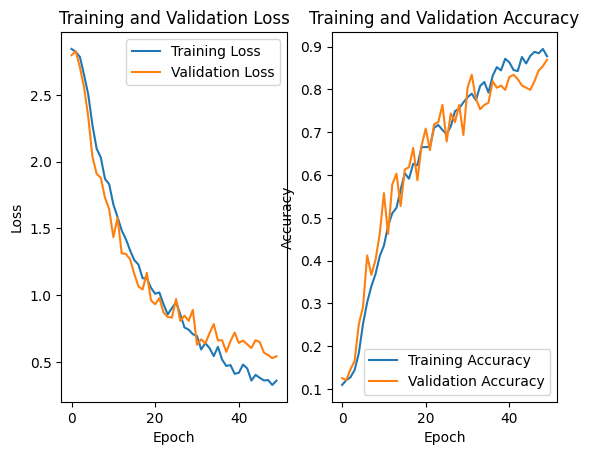

In [19]:
# Plot loss
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 17)             │         2,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,876,917 (37.68 MB)

 Trainable params: 3,292,305 (12.56 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 6,584,612 (25.12 MB)

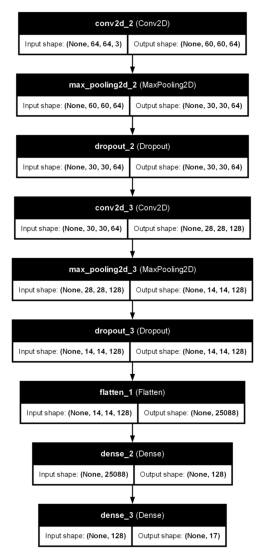

In [22]:
classifier.summary()
plot_model(classifier, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# resize the result of plot model
plt.figure(figsize=(10, 7))  
img = plt.imread('model_plot.png')  
plt.imshow(img)
plt.axis('off')  
plt.show()

Model Testing

In [21]:
model = load_model("model.h5")


def preprocess_image(img_array):
    # Transform into image, resize, transform back into numpy array, expand dimension and normalize values
    img = image.array_to_img(img_array, data_format=None, scale=True)
    img = img.resize((64, 64))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array


# Classify the input image
def classify_image(model, image_path):
    processed_image = preprocess_image(image_path)
    # Use model to predict based on the processed image
    prediction = model.predict(processed_image)
    return prediction


# Interpret the prediction
class_names = [
    "Angelina Jolie",
    "Brad Pitt",
    "Denzel Washington",
    "Hugh Jackman",
    "Jennifer Lawrence",
    "Johnny Depp",
    "Kate Winslet",
    "Leonardo DiCaprio",
    "Megan Fox",
    "Natalie Portman",
    "Nicole Kidman",
    "Robert Downey Jr",
    "Sandra Bullock",
    "Scarlett Johansson",
    "Tom Cruise",
    "Tom Hanks",
    "Will Smith",
]


def interpret_prediction(prediction):
    predicted_class_index = np.argmax(prediction)
    predicted_class_name = class_names[predicted_class_index]
    return predicted_class_name


if __name__ == "__main__":
    image_path = r"C:\\Users\\antop\\Desktop\\progetto\\smith.jpg"

    # Crop the image
    cropped = get_cropped_image_2_eyes(image_path)
    # Convert BGR to RGB
    cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB)

    # Classify the image and interpret the prediction
    prediction = classify_image(model, cropped)
    predicted_class_name = interpret_prediction(prediction)
    print(f"Prediction: {predicted_class_name}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Prediction: Will Smith


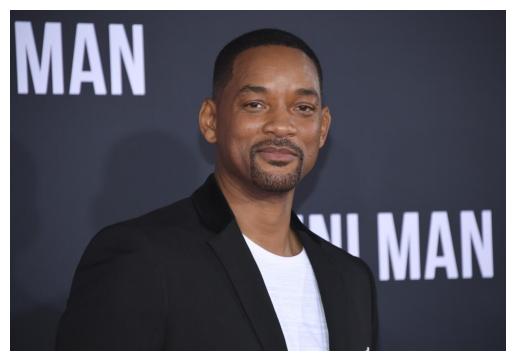

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image_path = "C:\\Users\\antop\\Desktop\\progetto\\smith.jpg"
img = mpimg.imread(image_path)
plt.imshow(img)
plt.axis('off')  # Optional: Hide axis ticks and labels
plt.show()